General notes:<br>
&nbsp; &nbsp; &nbsp; &nbsp; 1) Collapse some of the cells in groups.<br>
&nbsp; &nbsp; &nbsp; &nbsp; 1.1) If cells are not directly answering a question, collapse them together.<br>
&nbsp; &nbsp; &nbsp; &nbsp; 2) Add Markdown to identify sections<br>
&nbsp; &nbsp; &nbsp; &nbsp; 3) Review all comments <br>
&nbsp; &nbsp; &nbsp; &nbsp; 4) Add precision to all columns, graphics and tables to explain the variables or labels if needed <br>
&nbsp; &nbsp; &nbsp; &nbsp; 5) Standardiser les labels pour s'assurer qu'ils matchs ceux donnes dans le document

# Partie 1. Analyse préliminaire (20 points)

Définissons la série $y_t = log(100\times USDCAD_t)$ pour le reste de ce travail.<br>
**1.a) Chargez les données et ne gardez que les observations jusqu'à décembre 2019. Tracez la série
brute
avec des étiquettes sur chaque axe et un titre 'log(100 USDCAD=x)'. La dimension temporelle
doit apparaître sur l'axe des abscisses.**

In [14]:
#Import the packages necessary and set figure size for the project
import matplotlib.pyplot as plt
import matlab.engine
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResultsWrapper
from arch import arch_model
# Deactivate warnings
import warnings
warnings.filterwarnings('ignore')
# Set figure size for all plots
plt.rcParams["figure.figsize"] = (15, 6)

In [15]:
#Import the data
df = pd.read_csv("data_W2023.csv")

#Clean data and format the dataframe
df.columns = ["date", "USDCAD"]
df = df[df["date"] < "2020-01-01"]
df["date"] = pd.to_datetime(df["date"])

#Transform the raw data into our base variable
df["log_100_USDCAD"] = np.log(100 * df["USDCAD"])

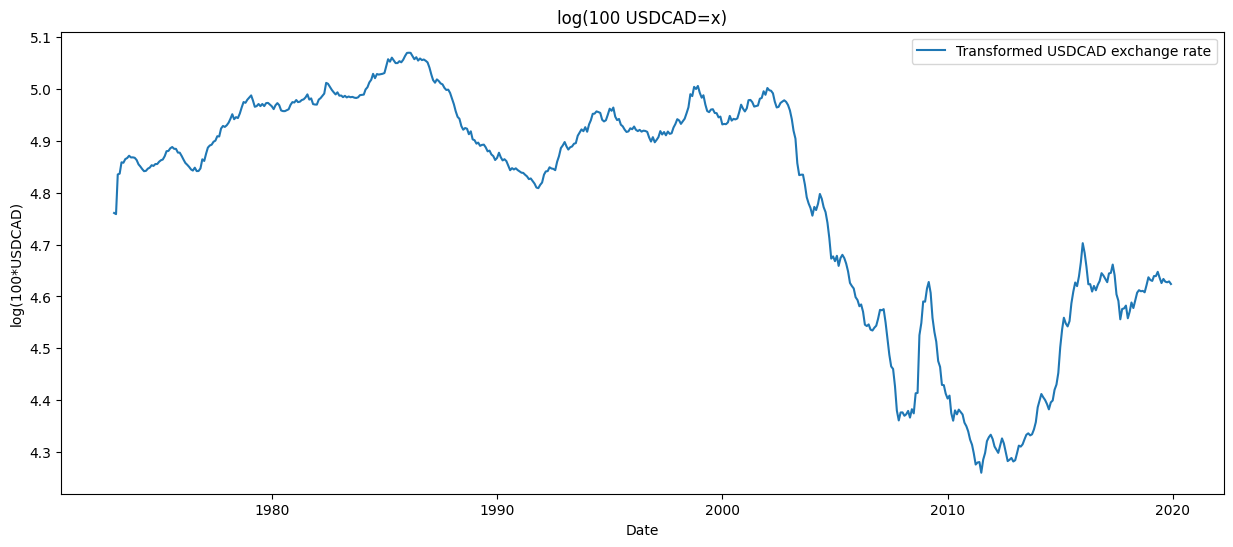

In [16]:
#Generate the plot
plt.plot(df["date"], df["log_100_USDCAD"])
plt.xlabel("Date")
plt.ylabel(f"log(100*USDCAD)")
plt.title("log(100 USDCAD=x)")
plt.legend(["Transformed USDCAD exchange rate"])

**1.b) Supposons qu'il existe une tendance temporelle déterministe (polynôme d'ordre 2) : $\tau_t = \alpha + \beta*t + \gamma*t^{2}$.<br>
Appliquez la transformation requise pour stationnariser la série logarithmique (le logarithme du taux de
change) et tracez la série résultante.**

In [17]:
Y = df["log_100_USDCAD"].values

T = len(Y)
trend = np.arange(1, T + 1)
ones = np.ones(T)
X = np.column_stack((ones, trend, trend ** 2))

#Estimate 
B = np.linalg.inv(X.T @ X) @ X.T @ Y

#Estimate the residuals
df["res"] = Y - X @ B

Text(0.5, 1.0, 'Determinist trend deviation')

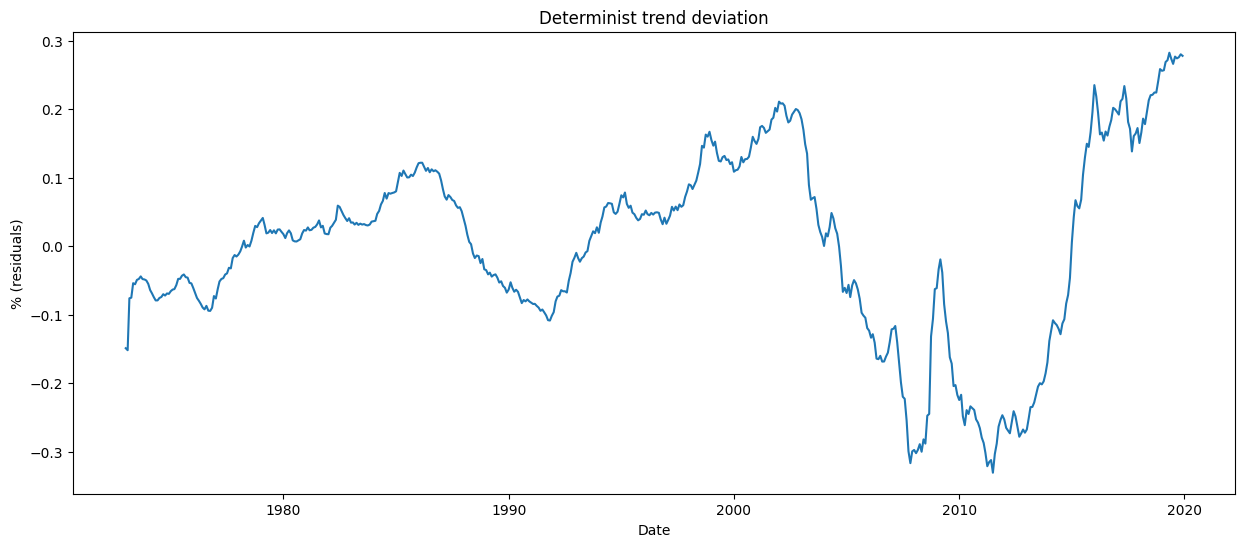

In [18]:
plt.plot(df["date"], df["res"])
plt.xlabel("Date")
plt.ylabel(f"% (residuals)")
plt.title("Determinist trend deviation")

**Interpretation**

**1.c) Supposons qu'il existe une tendance temporelle stochastique, c'est-à-dire une marche aléatoire.<br>
Appliquez la transformation requise pour stationnariser la série logarithmique (le logarithme du taux d'echange) et tracez la série résultante.**

Text(0.5, 1.0, 'Hypothesis: stochastic trend')

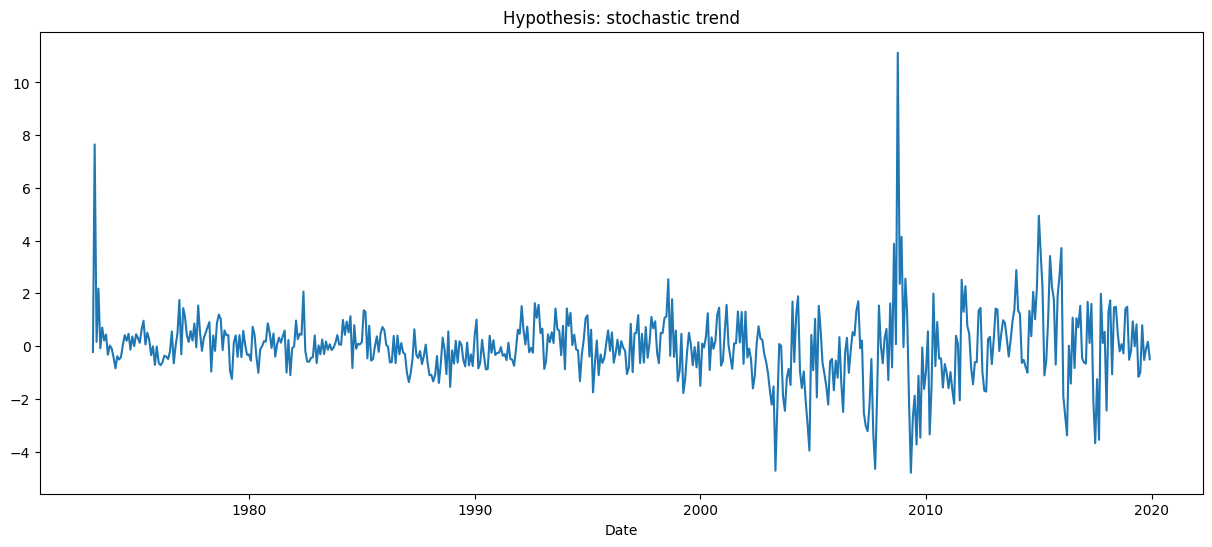

In [19]:
df_stoch = df.copy() # Copy to make first part robust if we run the project out of order
df_stoch["stoch_USDCAD"] = df_stoch["log_100_USDCAD"].diff() * 100
df_stoch.dropna(inplace=True) # Drop first row

plt.plot(df_stoch["date"], df_stoch["stoch_USDCAD"])
plt.xlabel("Date")
plt.title("Hypothesis: stochastic trend")

**1.d) Analyser les fonctions d'autocorrélation de l'échantillon pour évaluer si les séries sont stationnaires.<br>
Quelle série choisiriez-vous pour estimer un modèle de série chronologique?**

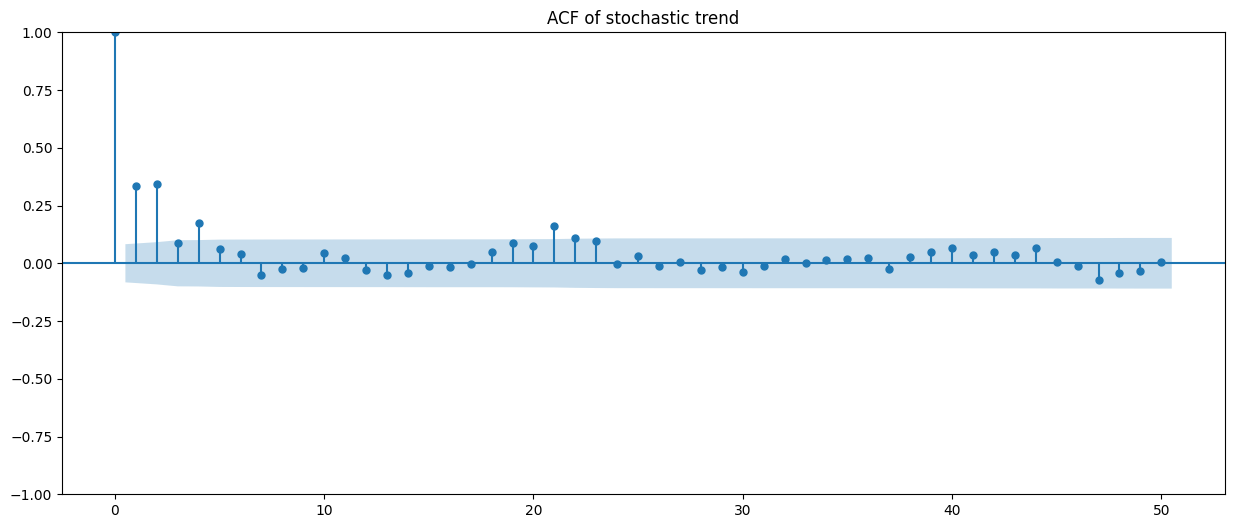

In [20]:
sm.graphics.tsa.plot_acf(df_stoch["stoch_USDCAD"], lags=50, title="ACF of stochastic trend");

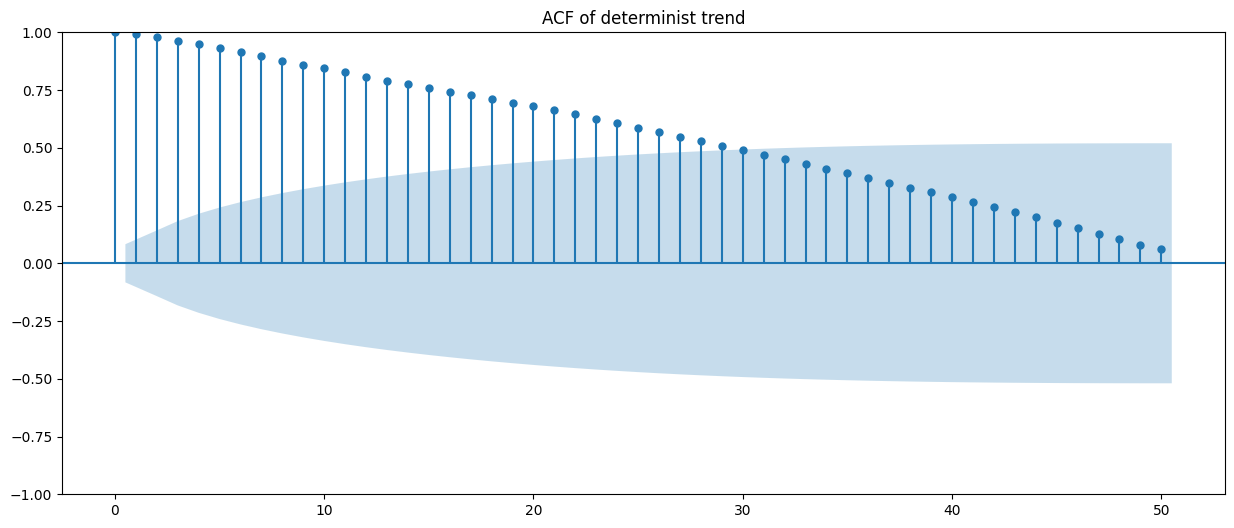

In [21]:
sm.graphics.tsa.plot_acf(df_stoch["res"], lags=50, title="ACF of determinist trend");

**Interpretation**

Pour commencer, on sait que l'autocorrélation non conditionnelle est une mesure de la dépendance temporelle, ce qui nous permet à partir des graphiques d'autocorrélations, de conclure sur la nature stationnaire de la série. On attend d'une série stationnaire des mouvements autour d'une moyenne et de bornes qui sont fixes dans le temps.


- Concernant le graphique des autocorrélations de la tendance déterministe polynomiale, on observe que les autocorrélations tendent lentement vers 0. La moyenne des autocorrélations n'est donc pas nulle. On peut donc conclure que la série `log_100_USDCAD` n'est pas stationnaire.
- D'autre part, on observe que les autocorrélations de la série à tendance stochastique tendent rapidement vers 0 pour les 50 lags testés, avec une moyenne qui à l'air nulle en fonction du nombre de lags.

On sait que tout processus stationnaire est caractérisé par une courte mémoire: $Corr(y_t, y_{t-k}) \rightarrow 0$ lorsque $k$ augmente. On peut donc conclure que la série `stoch_USDCAD` est stationnaire.

**1.e) A partir de maintenant, utilisez exclusivement la série qui est stationnaire. Effectuez les tests de Ljung-Box avec 1 à 18 lags pour vérifier si la série est un bruit blanc et concluez.**

In [22]:
ljung_box_test = sm.stats.acorr_ljungbox(df_stoch["stoch_USDCAD"], lags=18)
ljung_box_test[f"< 0.01"] = ljung_box_test["lb_pvalue"] < 0.01
ljung_box_test

,lb_stat,lb_pvalue,< 0.01
1,63.837877,1.350911e-15,True
2,130.932915,3.700656e-29,True
3,135.330291,3.838951e-29,True
4,153.014709,4.598552e-32,True
5,155.108804,1.090679e-31,True
6,156.108470,3.947901e-31,True
7,157.514338,1.069480e-30,True
8,157.903502,4.387614e-30,True
9,158.157909,1.792324e-29,True
10,159.368871,4.373649e-29,True


**Interpretation**

On rappelle que le test de Ljung-Box permet de tester l'hypothèse nulle d'absence d'autocorrélation pour les termes bruits blancs : $H_0: Corr(y_t, y_{t-k}) = 0$.

On remarque que les `lb_pvalues` (p-values pour le test de Ljung-Box) sont extrêmement faibles pour les lags 1 à 18. On peut donc rejeter l'hypothèse nulle d'absence de corrélation pour ces lags au seuil de 1%. On peut donc conclure que les résidus ne sont pas indépendants et que la série est autocorrélée, ce qui implique que le terme d'erreur de la série `stoch_USDCAD` n'est pas bruit blanc.

# Partie 2. Choix du modèle (30 points)

Considérons les 8 modèles suivants :
- AR(1): $y_t = \delta + \phi_1 y_{t-1} + \epsilon_t$
- AR(2): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t$
- AR(3): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \epsilon_t$
- AR(4): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \phi_4 y_{t-4} + \epsilon_t$
- ARMA(1,1): $y_t = \delta + \phi_1 y_{t-1} - \theta_1 \epsilon_{t-1} + \epsilon_t$
- ARMA(2,2): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} + \epsilon_t$
- ARMA(3,3): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \theta_3 \epsilon_{t-3} + \epsilon_t$
- ARMA(4,4): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \phi_4 y_{t-4} - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \theta_3 \epsilon_{t-3} - \theta_4 \epsilon_{t-4} + \epsilon_t$

**2.a) Estimez les 8 modèles par maximum de vraisemblance, présentez les résultats de l'estimation et 
vérifiez si les conditions de stationnarité sont satisfaites.**

In [23]:
def compute_eigenvalues(arma_model: ARIMAResultsWrapper) -> np.ndarray:
    """Compute the eigenvalues of the ARMA model."""

    # Find length of arparams
    arparams = arma_model.arparams # Store the AR parameters
    n_ar_params_1 = len(arparams) - 1

    # Make the params into a row array
    param_array = arparams.reshape((1, arparams.shape[0]))

    # Create sub array
    ones = np.ones(n_ar_params_1)
    diag_array = np.diag(ones).reshape((n_ar_params_1, n_ar_params_1))

    # Create array of 0s
    zero_col = np.zeros((n_ar_params_1, 1))

    # Stack array
    sub_array = np.hstack((diag_array, zero_col))
    eigmat = np.vstack((param_array, sub_array))

    return np.linalg.eigvals(eigmat) # Compute the eigenvalues of the matrix

In [24]:
def check_stationarity(eigenvalues: np.ndarray) -> bool:
    """Check if the eigenvalues of the ARMA model are inferior to 1."""
    if eigenvalues.dtype == np.complex128: # If eigenvalues are complex, calculate the norm
        a = np.real(eigenvalues)
        b = np.imag(eigenvalues)
        return all(np.sqrt(a**2 + b**2) < 1)
    else: # If eigenvalues are real, check if they are inferior to 1 in absolute value
        return all(np.abs(eigenvalues) < 1)

In [25]:
arma_models = {}

order_list = [([1], 0, [0]),
               ([1, 2], 0, [0]),
               ([1, 2, 3], 0, [0]),
               ([1, 2, 3, 4], 0, [0]),
               ([1], 0, [1]),
               ([1, 2], 0, [1, 2]),
               ([1, 2, 3], 0, [1, 2, 3]),
               ([1, 2, 3, 4], 0, [1, 2, 3, 4])]

for order in order_list:
    print(f"Autoregressive lags: {order[0]}")
    print(f"Moving average lags: {order[2]}")

    model = ARIMA(df_stoch["stoch_USDCAD"], order=order)
    results = model.fit()
    print(results.summary())
    arma_models[f"ARMA({order[0][-1]},{order[2][-1]})"] = results

Autoregressive lags: [1]
Moving average lags: [0]
                               SARIMAX Results                                
Dep. Variable:           stoch_USDCAD   No. Observations:                  563
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -919.472
Date:                Thu, 02 Mar 2023   AIC                           1844.945
Time:                        11:48:14   BIC                           1857.945
Sample:                             0   HQIC                          1850.020
                                - 563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0249      0.086     -0.291      0.771      -0.193       0.143
ar.L1          0.3353      0.031     10.804      0.000       0.274       0.396
si

In [26]:
df_stationarity = pd.DataFrame(index=arma_models.keys(), columns=["is_stationary"])

for model_name, model in arma_models.items():
    eigenvalues = compute_eigenvalues(model)
    df_stationarity.loc[model_name, "is_stationary"] = check_stationarity(eigenvalues)
    
df_stationarity

,is_stationary
"ARMA(1,0)",True
"ARMA(2,0)",True
"ARMA(3,0)",True
"ARMA(4,0)",True
"ARMA(1,1)",True
"ARMA(2,2)",True
"ARMA(3,3)",True
"ARMA(4,4)",True


On constate que les conditions de stationnarité sont satisfaites pour tous les modèles.

**2.b) Effectuez des tests de rapport de vraisemblance pour justifier la sélection de deux modèles. Sélectionnez d'abord le meilleur parmi AR(1), AR(2), AR(3) et AR(4). Sélectionnez ensuite le meilleur modèle parmi ARMA(1,1), ARMA(2,2), ARMA(3,3) et ARMA(4,4). Utilisez le BIC pour justifier la sélection du meilleur de ces deux modèles.**

In [27]:
def compute_lr_statistic(reduced_ll: float, full_ll: float) -> float:
    """Compute the likelihood ratio statistic.
    
    Args: 
        reduced_ll (float): Log likehood of the reduced model.
        full_ll (float): Log likehood of the full model.

    Returns:
        float: The Likehood-Ratio Test Statistics
    """
    return -2 * (reduced_ll - full_ll)

In [28]:
def compute_p_value_llr(reduced_ll: float, full_ll: float, df: int = 1) -> float:
    """Compute the p-value of the likelihood ratio test.
    
    Args: 
        reduced_ll (float): Log likehood of the reduced model.
        full_ll (float): Log likehood of the full model.
        df (int): Degree of freedom of the Chi-Square test.
    
    Returns:
        float: Returns the p-value of the test. That is the probability that the full model is better than the reduced model.
    """
    lr_statistic = compute_lr_statistic(reduced_ll=reduced_ll, full_ll=full_ll)
    p_val = sp.stats.chi2.sf(lr_statistic, df=df)
    return p_val

On commence par sélectionner le meilleur modèle parmi AR(1), AR(2), AR(3) et AR(4).

- H0: Le modèle complet ARMA(2,0) fit les données aussi bien que le modèle réduit ARMA(1,0). Par conséquent, on devrait choisir le modèle ARMA(1,0) car il est plus simple.
- H1: Le modèle complet ARMA(2,0) fit mieux les données que le modèle réduit ARMA(1,0). Par conséquent, on devrait choisir le modèle ARMA(2,0) car il est plus précis.

In [29]:
compute_p_value_llr(arma_models["ARMA(1,0)"].llf,
                    arma_models["ARMA(2,0)"].llf,
                    df=1)

7.820378576429521e-11

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(2,0) fit mieux les données que le modèle ARMA(1,0).

- H0: Le modèle complet ARMA(3,0) fit les données aussi bien que le modèle réduit ARMA(2,0). Par conséquent, on devrait choisir le modèle ARMA(2,0) car il est plus simple.
- H1: Le modèle complet ARMA(3,0) fit mieux les données que le modèle réduit ARMA(2,0). Par conséquent, on devrait choisir le modèle ARMA(3,0) car il est plus précis.

In [30]:
compute_p_value_llr(arma_models["ARMA(2,0)"].llf,
                    arma_models["ARMA(3,0)"].llf,
                    df=1)

0.007646861433316317

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(3,0) fit mieux les données que le modèle ARMA(2,0).

- H0: Le modèle complet ARMA(4,0) fit les données aussi bien que le modèle réduit ARMA(3,0). Par conséquent, on devrait choisir le modèle ARMA(3,0) car il est plus simple.
- H1: Le modèle complet ARMA(4,0) fit mieux les données que le modèle réduit ARMA(3,0). Par conséquent, on devrait choisir le modèle ARMA(4,0) car il est plus précis.

In [31]:
compute_p_value_llr(arma_models["ARMA(3,0)"].llf,
                    arma_models["ARMA(4,0)"].llf,
                    df=1)

0.006280983257625679

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(4,0) fit mieux les données que le modèle ARMA(3,0).

**On peut donc conclure que d'après le test du ratio de vraisemblance, le modèle AR(4) est le meilleur modèle pour modéliser les données parmis les modèles AR.**

On utilise le même raisonnement pour les modèles ARMA(p, q) afin de sélectionner le meilleur modèle parmi ARMA(1,1), ARMA(2,2), ARMA(3,3) et ARMA(4,4).

- H0: Le modèle complet ARMA(2,2) fit les données aussi bien que le modèle réduit ARMA(1,1). Par conséquent, on devrait choisir le modèle ARMA(1,1) car il est plus simple.
- H1: Le modèle complet ARMA(2,2) fit mieux les données que le modèle réduit ARMA(1,1). Par conséquent, on devrait choisir le modèle ARMA(2,2) car il est plus précis.

In [32]:
compute_p_value_llr(arma_models["ARMA(1,1)"].llf,
                    arma_models["ARMA(2,2)"].llf,
                    df=2)

5.093383915436467e-07

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(2,2) fit mieux les données que le modèle ARMA(1,1).

- H0: Le modèle complet ARMA(3,3) fit les données aussi bien que le modèle réduit ARMA(2,2). Par conséquent, on devrait choisir le modèle ARMA(2,2) car il est plus simple.
- H1: Le modèle complet ARMA(3,3) fit mieux les données que le modèle réduit ARMA(2,2). Par conséquent, on devrait choisir le modèle ARMA(3,3) car il est plus précis.

In [33]:
compute_p_value_llr(arma_models["ARMA(2,2)"].llf,
                    arma_models["ARMA(3,3)"].llf,
                    df=2)

0.3676921427807781

Comme la p-value est supérieur au seuil significatif de 5%, on ne peut pas rejeter l'hypothèse nulle et on peut donc conclure que le modèle ARMA(2,2) fit aussi bien les données que le modèle ARMA(3,3). Par conséquent, on devrait choisir le modèle ARMA(2,2) car il est plus simple.

In [34]:
compute_p_value_llr(arma_models["ARMA(2,2)"].llf,
                    arma_models["ARMA(4,4)"].llf,
                    df=4)

0.3432525503882037

**On peut donc conclure que d'après le test du ratio de vraisemblance, le modèle ARMA(2,2) est le meilleur modèle pour modéliser les données parmis les modèles ARMA.**

In [35]:
df_bic = pd.DataFrame({"BIC": [arma_models["ARMA(2,2)"].bic, arma_models["ARMA(4,0)"].bic]},
                      index=["ARMA(2,2)", "AR(4)"])
df_bic

,BIC
"ARMA(2,2)",1822.798787
AR(4),1820.059890


On remarque que le BIC du modèle AR(4) est plus petit que celui du modèle ARMA(2,2). Par conséquent, et d'après le critère d'information de Bayes, le modèle AR(4) est le meilleur modèle pour modéliser les données.

**2.c) Évaluez l'hypothèse du bruit blanc pour chacun des deux modèles, et pour le modèle AR(1). Que 
pouvons-nous conclure ?**

In [36]:
resid_arma_2_2 = arma_models["ARMA(2,2)"].resid
resid_arma_4_0 = arma_models["ARMA(4,0)"].resid
resid_arma_1_0 = arma_models["ARMA(1,0)"].resid

sm.stats.acorr_ljungbox(resid_arma_2_2, lags=18, return_df=True)

,lb_stat,lb_pvalue
1,0.019365,0.889326
2,0.687187,0.709217
3,0.707994,0.871322
4,1.595710,0.809563
5,4.884819,0.430098
6,5.217740,0.516205
7,6.400846,0.493800
8,7.974911,0.435925
9,8.162355,0.517871
10,10.680986,0.382906


In [37]:
# Check that all lb_pvalues are > 0.05
all(sm.stats.acorr_ljungbox(resid_arma_2_2, lags=18, return_df=True).lb_pvalue > 0.05)

True

Après avoir effectué le test de Ljung-Box sur le modèle ARMA(2,2), on remarque que la p-value est supérieur au seuil significatif de 5% pour tous les 18 lags. Par conséquent, on ne peut pas rejeter l'hypothèse nulle que le terme d'erreur possède des autocorrélations de 0. Par conséquent, on peut conclure que le terme d'erreur du modèle ARMA(2,2) est un bruit blanc.

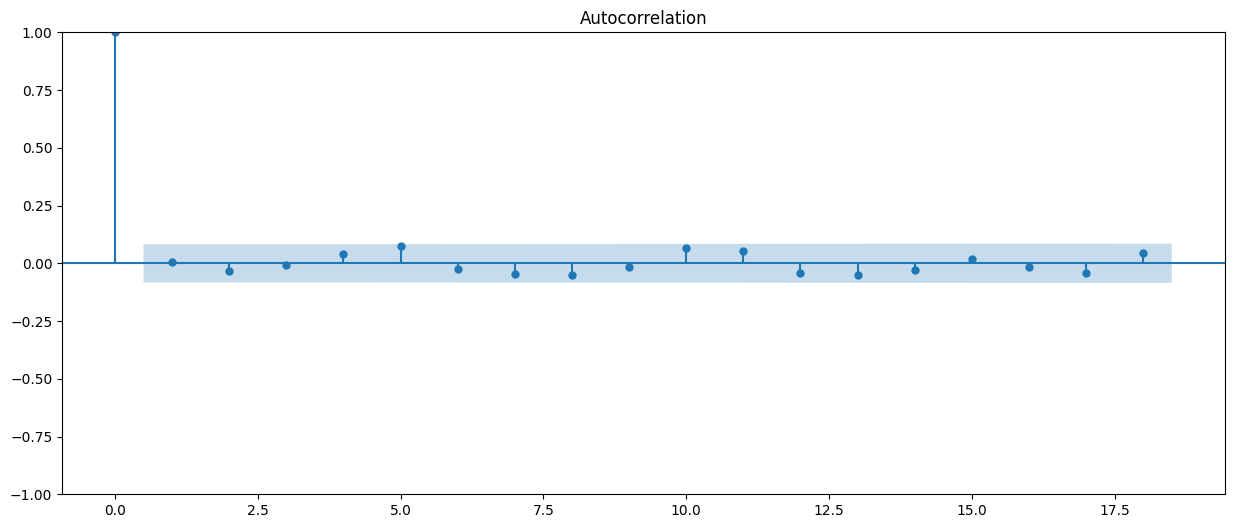

In [38]:
# Autocorrelation plot to confirm our results
fig, ax = plt.subplots(figsize=(15, 6))
fig = sm.graphics.tsa.plot_acf(resid_arma_2_2, lags=18, ax=ax)


In [39]:
sm.stats.acorr_ljungbox(resid_arma_4_0, lags=18, return_df=True)

,lb_stat,lb_pvalue
1,0.022608,0.880481
2,0.160005,0.923114
3,0.284247,0.962964
4,0.286832,0.990648
5,0.827707,0.975233
6,1.626631,0.950644
7,3.507857,0.834393
8,4.859857,0.772444
9,5.277459,0.809482
10,7.568857,0.670869


In [40]:
# Check that all lb_pvalues are > 0.05
all(sm.stats.acorr_ljungbox(resid_arma_4_0, lags=18, return_df=True).lb_pvalue > 0.05)

True

Après avoir effectué le test de Ljung-Box sur le modèle AR(4), on remarque que la p-value est supérieur au seuil significatif de 5% pour tous les 18 lags. Par conséquent, on ne peut pas rejeter l'hypothèse nulle que le terme d'erreur possède des autocorrélations de 0. Par conséquent, on peut conclure que le terme d'erreur du modèle AR(4) est un bruit blanc.

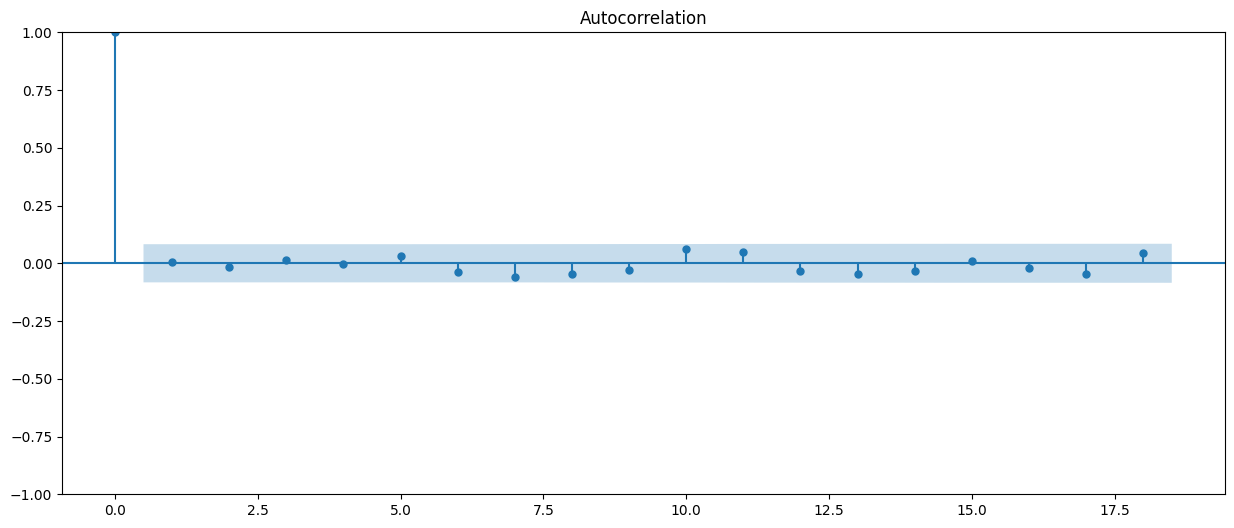

In [41]:
# Autocorrelation plot to confirm our results
fig, ax = plt.subplots(figsize=(15, 6))
fig = sm.graphics.tsa.plot_acf(resid_arma_4_0, lags=18, ax=ax)

In [42]:
sm.stats.acorr_ljungbox(resid_arma_1_0, lags=18, return_df=True)

,lb_stat,lb_pvalue
1,4.261575,3.898377e-02
2,45.933833,1.060706e-10
3,50.167877,7.357811e-11
4,65.664649,1.863951e-13
5,65.689926,8.060455e-13
6,67.027592,1.661358e-12
7,69.662315,1.728765e-12
8,69.683916,5.680488e-12
9,70.341134,1.305289e-11
10,72.165245,1.690236e-11


In [43]:
# Check that all lb_pvalues are < 0.05
all(sm.stats.acorr_ljungbox(resid_arma_1_0, lags=18, return_df=True).lb_pvalue < 0.05)

True

Après avoir effectué le test de Ljung-Box sur le modèle AR(1), on remarque que la p-value est inférieur au seuil significatif de 5% pour tous les 18 lags. Par conséquent, on peut rejeter l'hypothèse nulle que le terme d'erreur possède des autocorrélations de 0. Par conséquent, on peut conclure que le terme d'erreur du modèle AR(1) n'est pas un bruit blanc.

# Partie 3. Réponse dynamique et prévision (20 points)

**3.a) Pour les deux modèles sélectionnés, évaluez la réponse dynamique pour un horizon de 10 périodes suite à un choc positif de taille $\sigma = 1.15$ survenant à la première période de l'horizon. Tracez les deux fonctions de réponse impulsionnelle sur la même figure et commentez.**

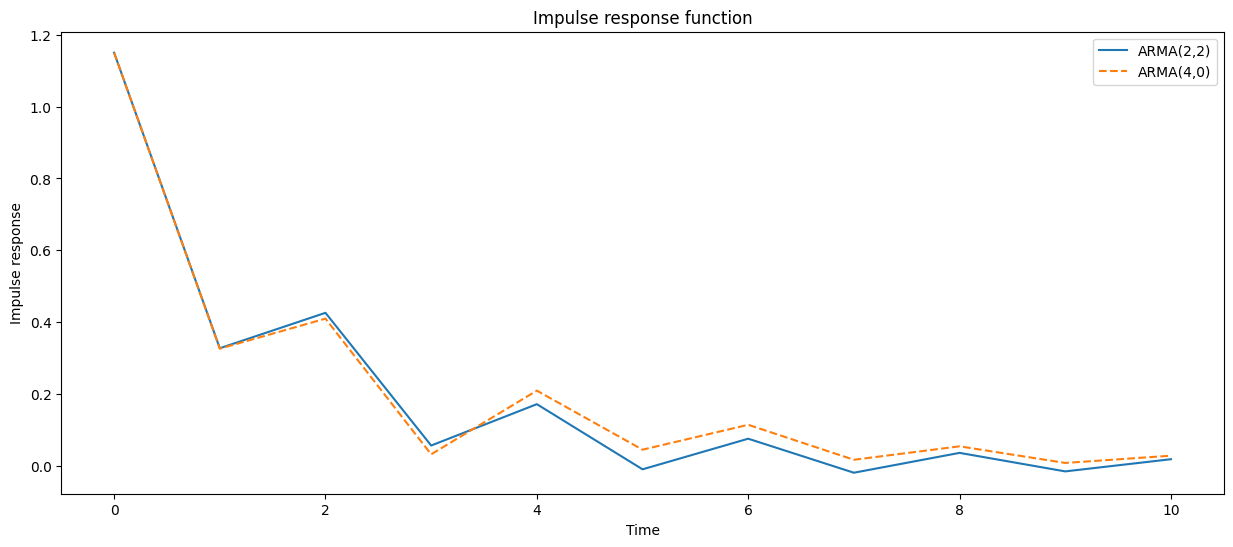

In [44]:
sigma = 1.15
impulse_res_arma22 = arma_models["ARMA(2,2)"].impulse_responses(steps=10, impulse=[sigma])
impulse_res_arma40 = arma_models["ARMA(4,0)"].impulse_responses(steps=10, impulse=[sigma])

plt.plot(impulse_res_arma22, label="ARMA(2,2)")
plt.plot(impulse_res_arma40, label="ARMA(4,0)", linestyle="--")
plt.legend()
plt.title("Impulse response function")
plt.xlabel("Time")
plt.ylabel("Impulse response")
plt.show()

Commentaire à ajouter...

**3.b) Un choc négatif de taille $\sigma = 1.15$ se produit pendant 3 périodes consécutives de l'horizon (t, t+1, t+2). Tracez les deux fonctions de réponse impulsionnelle pour les deux modèles sélectionnés,
montrant la réponse dynamique pour un horizon de 20 périodes après ces chocs, et expliquez ce qui se passe.**

In [292]:
def compute_three_impulse(arma_model, sigma, steps):
    first_impulse = arma_model.impulse_responses(steps=steps, impulse=[-sigma])
    second_impulse = first_impulse
    second_impulse = pd.concat([pd.Series([0]), second_impulse], ignore_index=True)
    second_impulse = second_impulse[0:-1]
    third_impulse = first_impulse
    third_impulse = pd.concat([pd.Series([0, 0]), third_impulse], ignore_index=True)
    third_impulse = third_impulse[0:-2]
    total_impulse = first_impulse + second_impulse + third_impulse
    return total_impulse

In [289]:
def compute_impulse(arma_model, sigma, steps, nb_impulse = 3):
    impulse = arma_model.impulse_responses(steps=steps, impulse=[-sigma])
    third_impulse = second_impulse = impulse
    second_impulse = pd.concat([pd.Series(np.zeros(nb_impulse - 1).astype(np.int64)), second_impulse], ignore_index=True)
    third_impulse = pd.concat([pd.Series(np.zeros(nb_impulse - 2).astype(np.int64)), third_impulse], ignore_index=True)
    total_impulse = impulse + second_impulse + third_impulse
    total_impulse = total_impulse[0:-2]
    return total_impulse

In [190]:
arma22_total_impulse_2 = compute_impulse(arma_models["ARMA(2,2)"], sigma, steps, nb_impulse = 3)
arma22_total_impulse_2

0    -1.150000
1    -1.477488
2    -1.903556
3    -0.810223
4    -0.654546
5    -0.218952
6    -0.237949
7    -0.047132
8    -0.092901
9    -0.001931
10   -0.039517
11    0.006959
12   -0.018343
13    0.006604
14   -0.009179
15    0.004645
16   -0.004858
17    0.002953
18   -0.002668
19    0.001794
20   -0.001499
dtype: float64

In [191]:
arma22_total_impulse_2 - arma22_total_impulse

0     0.000000e+00
1     0.000000e+00
2    -2.220446e-16
3     0.000000e+00
4     1.110223e-16
5     0.000000e+00
6     0.000000e+00
7     6.938894e-18
8     0.000000e+00
9     3.469447e-18
10    0.000000e+00
11   -1.734723e-18
12    0.000000e+00
13   -1.734723e-18
14    0.000000e+00
15   -8.673617e-19
16   -8.673617e-19
17    4.336809e-19
18   -4.336809e-19
19    0.000000e+00
20   -2.168404e-19
dtype: float64

In [291]:
arma22_total_impulse = compute_three_impulse(arma_models["ARMA(2,2)"], sigma, steps)
arma22_total_impulse

(21,)


0    -1.150000
1    -1.477488
2    -1.903556
3    -0.810223
4    -0.654546
5    -0.218952
6    -0.237949
7    -0.047132
8    -0.092901
9    -0.001931
10   -0.039517
11    0.006959
12   -0.018343
13    0.006604
14   -0.009179
15    0.004645
16   -0.004858
17    0.002953
18   -0.002668
19    0.001794
20   -0.001499
dtype: float64

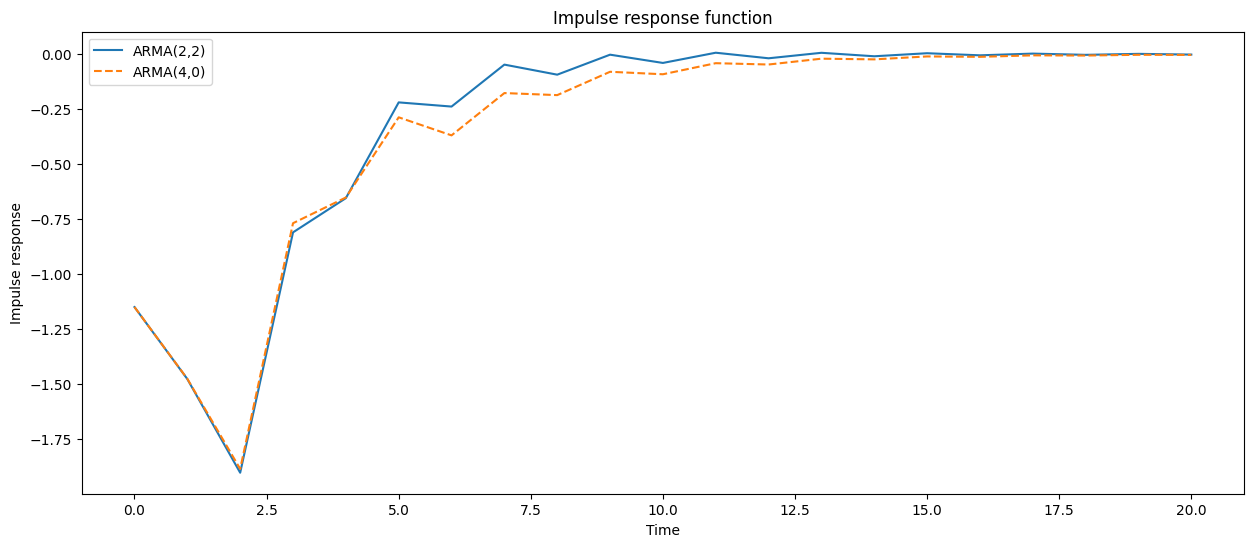

In [46]:
steps = 20
arma22_total_impulse = compute_three_impulse(arma_models["ARMA(2,2)"], sigma, steps)
arma40_total_impulse = compute_three_impulse(arma_models["ARMA(4,0)"], sigma, steps)

plt.plot(arma22_total_impulse, label="ARMA(2,2)")
plt.plot(arma40_total_impulse, label="ARMA(4,0)", linestyle="--")
plt.legend()
plt.title("Impulse response function")
plt.xlabel("Time")
plt.ylabel("Impulse response")
plt.show()

Explication à ajouter...

**3.c) Prévision : Divisez l'échantillon en un échantillon d'entraînement (training sample) et un échantillon de validation (holdout sample). L'échantillon de validation devrait être composé des 34 dernières observations.**

**• Ré-estimez les deux modèles sélectionnés en utilisant uniquement l'échantillon d'entraînement.<br>
• Pour chacun des deux modèles, calculez les prévisions à un pas en avant : $\mathbb{E}_t(USDCAD_{t+1})$ pour les
modèles AR(4) et ARMA(4,4).<br>
• Tracez ces prévisions avec la série réelle (différence première) sur le même graphique pour la période
couverte par l'échantillon de validation.<br>
• Tracez la série réelle (données brutes en niveaux) contre les prévisions à un pas d'avance et la prévision
naïve : $\mathbb{E}_t(USDCAD_{t+1}) = USDCAD_t$.**



In [47]:
# Estimate both models on training sample
treshold = 34
train_sample = df_stoch["stoch_USDCAD"].iloc[:-treshold]
val_sample = df_stoch["stoch_USDCAD"].iloc[-treshold:]

arma_models2 = {}
order_list = [([1, 2, 3, 4], 0, [0]),
               ([1, 2], 0, [1, 2]),
               ([1, 2, 3, 4], 0, [1, 2, 3, 4])]

for order in order_list:
    print(f"Autoregressive lags: {order[0]}")
    print(f"Moving average lags: {order[2]}")

    model = ARIMA(train_sample, order=order)
    results = model.fit()
    print(results.summary())
    arma_models2[f"ARMA({order[0][-1]},{order[2][-1]})"] = results

Autoregressive lags: [1, 2, 3, 4]
Moving average lags: [0]
                               SARIMAX Results                                
Dep. Variable:           stoch_USDCAD   No. Observations:                  529
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -826.065
Date:                Thu, 02 Mar 2023   AIC                           1664.130
Time:                        11:48:18   BIC                           1689.756
Sample:                             0   HQIC                          1674.161
                                - 529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0176      0.122     -0.144      0.886      -0.257       0.222
ar.L1          0.3024      0.036      8.376      0.000       0.232      

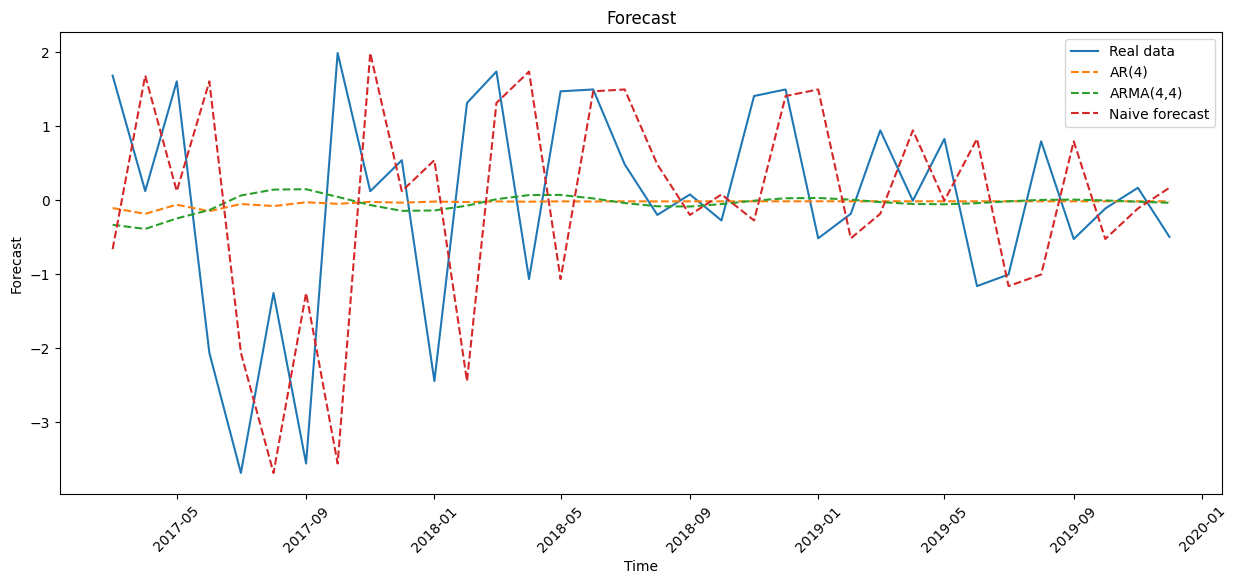

In [48]:
# Compute predictions for one period ahead
forecast_arma40 = arma_models2["ARMA(4,0)"].forecast(steps=treshold).reset_index(drop=True)
forecast_arma44 = arma_models2["ARMA(4,4)"].forecast(steps=treshold).reset_index(drop=True)

val_sample.reset_index(drop=True)
forecast_naive = np.zeros(treshold)
forecast_naive[0] = train_sample.iloc[-1]
forecast_naive[1:] = val_sample.iloc[:-1]

# Change index to date for plotting
forecast_arma40.index = df_stoch["date"].iloc[-treshold:]
forecast_arma44.index = df_stoch["date"].iloc[-treshold:]
val_sample.index = df_stoch["date"].iloc[-treshold:]
forecast_naive = pd.Series(forecast_naive, index=df_stoch["date"].iloc[-treshold:])


plt.plot(val_sample, label="Real data")
plt.plot(forecast_arma40, label="AR(4)", linestyle="--")
plt.plot(forecast_arma44, label="ARMA(4,4)", linestyle="--")
plt.plot(forecast_naive, label="Naive forecast", linestyle="--")
plt.legend()
plt.title("Forecast")
plt.xlabel("Time")
# Rotate xticks by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Forecast")
plt.show()

**3.d) Indiquez l'erreur quadratique moyenne pour chaque modèle en utilisant uniquement l'échantillon de 34 observations pour évaluer la performance de la prévision. Comparez ces statistiques à l'estimateur naïf suivant : $\mathbb{E}_t(y_{t+1}) = y_t$ pour h=1 seulement. Quel modèle devrions-nous utiliser dans chaque cas ?**


In [49]:
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mse_arma40 = compute_mse(val_sample, forecast_arma40)
mse_arma44 = compute_mse(val_sample, forecast_arma44)
mse_naive = compute_mse(val_sample, forecast_naive)

mse_df = pd.DataFrame({"AR(4)": mse_arma40,
                       "ARMA(4,4)": mse_arma44,
                       "Naive forecast": mse_naive},
                      index=["MSE"])
mse_df

,AR(4),"ARMA(4,4)",Naive forecast
MSE,1.986487,2.087125,3.832131


On peut conclure que le meilleur modèle à utiliser dans ce cas est le modèle AR(4), car il réduit le plus l'erreur quadratique moyenne sur les prévisions de l'échantillon de validation.

# Partie 4. Améliorations supplémentaires par la modélisation de la variance conditionnelle (30 points)

**4.a) Tracez les fonctions d'autocorrélation et d'autocorrélation partielle de $y_t^2$. Que pouvez-vous conclure ?**

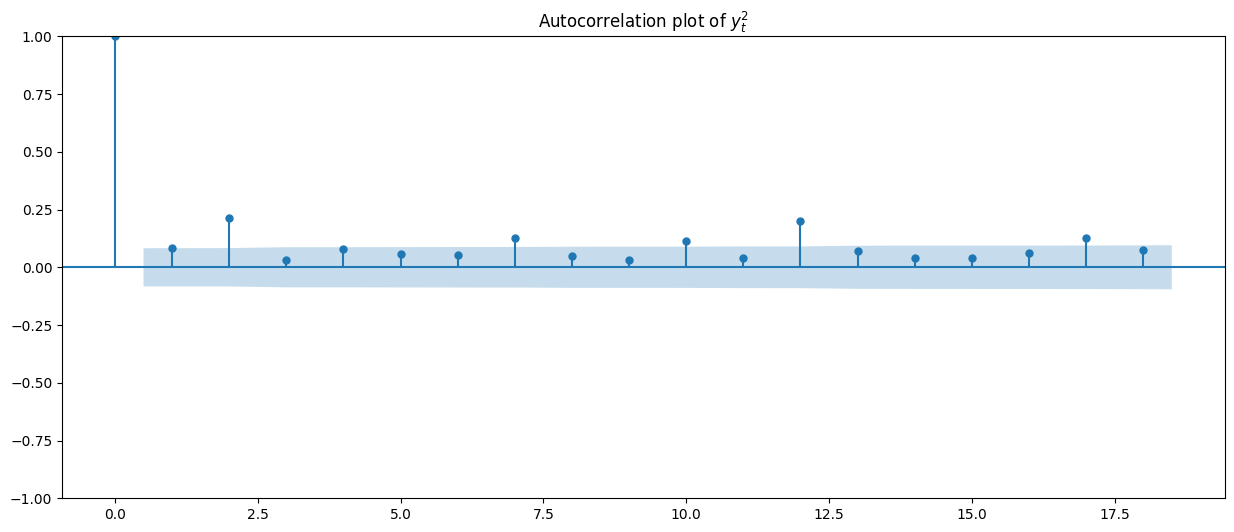

In [50]:
df_stoch["stoch_USDCAD**2"] = df_stoch["stoch_USDCAD"] ** 2

# Plot autocorrelation
sm.graphics.tsa.plot_acf(df_stoch["stoch_USDCAD**2"], lags=18, title=f"Autocorrelation plot of $y_t^2$");

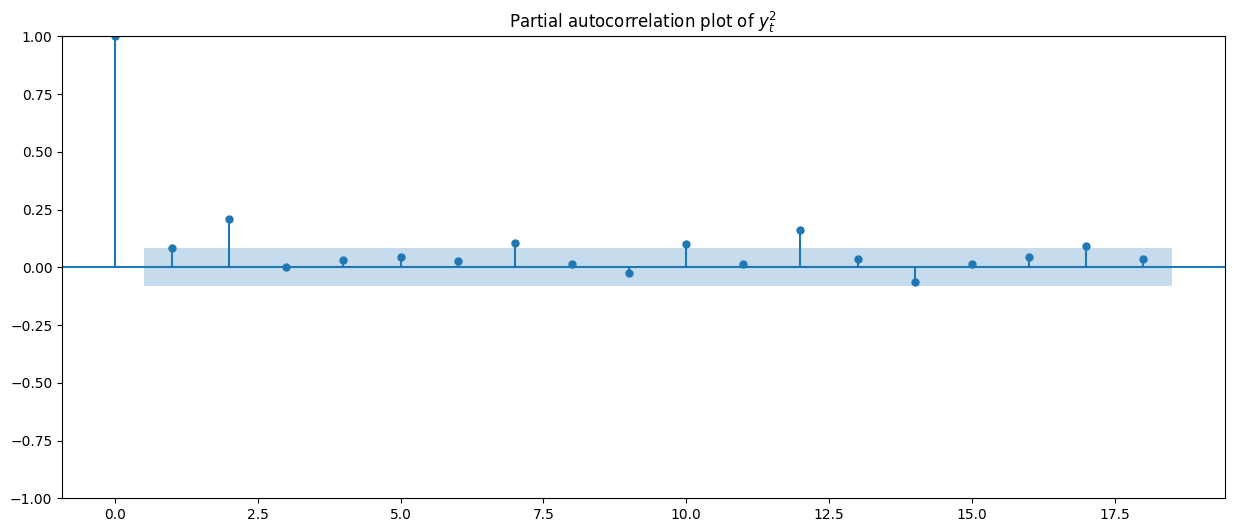

In [51]:
# Plot partial autocorrelation
sm.graphics.tsa.plot_pacf(df_stoch["stoch_USDCAD**2"], lags=18, title=f"Partial autocorrelation plot of $y_t^2$");

Conclusion à ajouter...

**4.b) Estimez les versions ARCH(1) et GARCH(1,1) des deux modèles sélectionnés par maximum de vraisemblance en utilisant seulement l'échantillon d'entraînement, et rapportez les estimations.**


In [52]:
def compute_arima_garch_models(train_sample: pd.Series,
                               p_arima: int,
                               q_arima: int,
                               p_garch: int,
                               q_garch: int,
                               vol: str = "GARCH"):
    """Compute ARIMA and GARCH models."""
    # Estimate ARIMA model
    arima = ARIMA(train_sample, order=(p_arima, 0, q_arima))
    arima_results = arima.fit()
    arima_resid = arima_results.resid

    # Estimate GARCH model
    garch = arch_model(arima_resid, p=p_garch, q=q_garch, vol=vol)
    garch_results = garch.fit(disp="off")

    return arima_results, garch_results

In [53]:
# Estimate a AR(4)ARCH(1) model
ar4, ar4arch1 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=0, p_garch=1, q_garch=0, vol="ARCH")
ar4arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -820.306
Distribution:                  Normal   AIC:                           1646.61
Method:            Maximum Likelihood   BIC:                           1659.42
                                        No. Observations:                  529
Date:                Thu, Mar 02 2023   Df Residuals:                      528
Time:                        11:48:20   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0315  4.987e-02      0.632      0.527 [-6.623e-02,  0.129]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.1086      0.306      3.624  2.896e-04    [  0.509,  1.708]
alpha[1]       0.2122      0.123      1.719  8.553e-02 [-2.968e-02,  0.454]
===========================================================================

Covariance estimator: robust
"""

In [54]:
# Estimate a AR(4)GARCH(1,1) model
ar4, ar4garch11 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=0, p_garch=1, q_garch=1, vol="GARCH")
ar4garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.595
Distribution:                  Normal   AIC:                           1457.19
Method:            Maximum Likelihood   BIC:                           1474.27
                                        No. Observations:                  529
Date:                Thu, Mar 02 2023   Df Residuals:                      528
Time:                        11:48:20   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.2359e-03  3.032e-02      0.239      0.811 [-5.219e-02,6.666e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0426  1.743e-02      2.446  1.446e-02 [8.465e-03,7.677e-02]
alpha[1]       0.2892  9.709e-02      2.978  2.899e-03   [9.887e-02,  0.479]
beta[1]        0.7065  6.366e-02     11.098  1.280e-28     [  0.582,  0.831]
============================================================================

Covariance estimator: robust
"""

In [55]:
# Estimate a ARMA(4,4)ARCH(1) model
arma44, arma44arch1 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=4, p_garch=1, q_garch=0, vol="ARCH")
arma44arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -818.345
Distribution:                  Normal   AIC:                           1642.69
Method:            Maximum Likelihood   BIC:                           1655.50
                                        No. Observations:                  529
Date:                Thu, Mar 02 2023   Df Residuals:                      528
Time:                        11:48:21   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0206  4.734e-02      0.436      0.663 [-7.214e-02,  0.113]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.1587      0.307      3.772  1.620e-04    [  0.557,  1.761]
alpha[1]       0.1388      0.109      1.271      0.204 [-7.527e-02,  0.353]
===========================================================================

Covariance estimator: robust
"""

In [56]:
# Estimate a ARMA(4,4)GARCH(1,1) model
arma44, arma44garch11 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=4, p_garch=1, q_garch=1, vol="GARCH")
arma44garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -731.481
Distribution:                  Normal   AIC:                           1470.96
Method:            Maximum Likelihood   BIC:                           1488.05
                                        No. Observations:                  529
Date:                Thu, Mar 02 2023   Df Residuals:                      528
Time:                        11:48:22   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.5877e-03  3.325e-02      0.258      0.796 [-5.657e-02,7.375e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0428  1.862e-02      2.301  2.141e-02 [6.345e-03,7.934e-02]
alpha[1]       0.2276  8.663e-02      2.627  8.603e-03   [5.782e-02,  0.397]
beta[1]        0.7538  6.148e-02     12.262  1.452e-34     [  0.633,  0.874]
============================================================================

Covariance estimator: robust
"""

**4.c) Effectuez des tests de rapport de vraisemblance pour sélectionner un modèle entre AR(4), AR(4) ARCH(1), et AR(4) GARCH(1,1). Répétez cette procédure pour sélectionner un modèle entre ARMA(4,4), ARMA(4,4) ARCH(1), et ARMA(4,4) GARCH(1,1).**


- H0: Le modèle complet AR(4)-ARCH(1) fit les données aussi bien que le modèle réduit AR(4). Par conséquent, on devrait choisir le modèle AR(4) car il est plus simple.
- H1: Le modèle complet AR(4)-ARCH(1) fit mieux les données que le modèle réduit AR(4). Par conséquent, on devrait choisir le modèle AR(4)-ARCH(1) car il est plus précis.

In [57]:
compute_p_value_llr(ar4.llf,
                    ar4arch1.loglikelihood,
                    df=2)

0.0031534656293441933

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle AR(4)-ARCH(1).

- H0: Le modèle complet AR(4)-GARCH(1,1) fit les données aussi bien que le modèle réduit AR(4)-ARCH(1). Par conséquent, on devrait choisir le modèle ARMA(4,4) car il est plus simple.
- H1: Le modèle complet AR(4)-GARCH(1,1) fit mieux les données que le modèle réduit AR(4)-ARCH(1). Par conséquent, on devrait choisir le modèle AR(4)-GARCH(1,1) car il est plus précis.

In [58]:
compute_p_value_llr(ar4arch1.loglikelihood,
                    ar4garch11.loglikelihood,
                    df=1)

1.5560401305834263e-43

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle AR(4)-GARCH(1,1).

- H0: Le modèle complet ARMA(4,4)-ARCH(1) fit les données aussi bien que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4) car il est plus simple.
- H1: Le modèle complet ARMA(4,4)-ARCH(1) fit mieux les données que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4)-ARCH(1) car il est plus précis.

In [59]:
compute_p_value_llr(arma44.llf,
                    arma44arch1.loglikelihood,
                    df=2)

0.3764463558647619

Comme la p-value est inférieure à 0.05, on ne peut pas rejeter l'hypothèse nulle et on choisit le modèle ARMA(4,4).

- H0: Le modèle complet ARMA(4,4)-GARCH(1,1) fit les données aussi bien que le modèle réduit ARMA(4,4)-ARCH(1). Par conséquent, on devrait choisir le modèle ARMA(4,4)-ARCH(1) car il est plus simple.
- H1: Le modèle complet ARMA(4,4)-GARCH(1,1) fit mieux les données que le modèle réduit ARMA(4,4)-ARCH(1). Par conséquent, on devrait choisir le modèle ARMA(4,4)-GARCH(1,1) car il est plus précis.

In [60]:
compute_p_value_llr(arma44arch1.loglikelihood,
                    arma44garch11.loglikelihood,
                    df=1)

1.1346354300030327e-39

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle ARMA(4,4)-GARCH(1,1).

- H0: Le modèle complet ARMA(4,4)-GARCH(1,1) fit les données aussi bien que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4) car il est plus simple.
- H1: Le modèle complet ARMA(4,4)-GARCH(1,1) fit mieux les données que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4)-GARCH(1,1) car il est plus précis.

In [61]:
compute_p_value_llr(arma44.llf,
                    arma44garch11.loglikelihood,
                    df=3)

7.547020245331992e-38

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle ARMA(4,4)-GARCH(1,1).

**On devrait donc choisir le modèle ARMA(4,4)-GARCH(1,1) et AR(4)-GARCH(1,1) d'après le critère du ratio de vraisemblance.**

**4.d) Effectuez un test de spécification sur les résidus pour AR(4) ARCH(1) et AR(4) GARCH(1,1). Quel est le meilleur modèle pour la variance conditionnelle ?**

In [62]:
def compute_specification_test(resid_square: pd.Series, h_t: pd.Series) -> pd.Series:
    """
    Compute the specification test for the conditional variance
    :param resid_square: the squared residuals
    :param h_t: the conditional variance
    :return: the specification test
    """
    return resid_square / h_t

In [63]:
ar4arch1_resid_sq = ar4arch1.resid.reset_index(drop=True) ** 2
ar4garch11_resid_sq = ar4garch11.resid.reset_index(drop=True) ** 2

# Get ar4arch1 parameters
alpha_0 = ar4arch1.params.iloc[1]
alpha_1 = ar4arch1.params.iloc[2]

# Compute variance of AR(4) ARCH(1) model
ar4arch1_h = np.zeros(len(ar4arch1_resid_sq))
# Initial guess for conditionnal variance
ar4arch1_h[0] = alpha_0 / (1 - alpha_1)

for i in range(1, len(ar4arch1_resid_sq)):
    ar4arch1_h[i] = alpha_0 + alpha_1 * ar4arch1_resid_sq[i-1]

In [64]:
# Get ar4garch11 parameters
alpha_0 = ar4garch11.params.iloc[1]
alpha_1 = ar4garch11.params.iloc[2]
beta_1 = ar4garch11.params.iloc[3]

# Compute variance of AR(4) GARCH(1,1) model
ar4garch11_h = np.zeros(len(ar4garch11_resid_sq))
# Initial guess
ar4garch11_h[0] = alpha_0 / (1 - alpha_1 - beta_1)

for i in range(1, len(ar4garch11_resid_sq)):
    ar4garch11_h[i] = alpha_0 + alpha_1 * ar4garch11_resid_sq[i-1] + beta_1 * ar4garch11_h[i-1]

In [65]:
# Compute specification test
ar4arch1_spec_test = compute_specification_test(ar4arch1_resid_sq, ar4arch1_h)
ar4garch11_spec_test = compute_specification_test(ar4garch11_resid_sq, ar4garch11_h)

# Use ljung box test on the specification test
ar4arch1_ljung_box = sm.stats.acorr_ljungbox(ar4arch1_spec_test, lags=18)
ar4arch1_ljung_box

,lb_stat,lb_pvalue
1,0.065457,0.798069
2,2.704905,0.258605
3,2.723726,0.436210
4,2.879816,0.578135
5,3.110696,0.682924
6,7.111502,0.310659
7,7.689660,0.360753
8,7.731774,0.460100
9,7.736727,0.560880
10,14.642018,0.145668


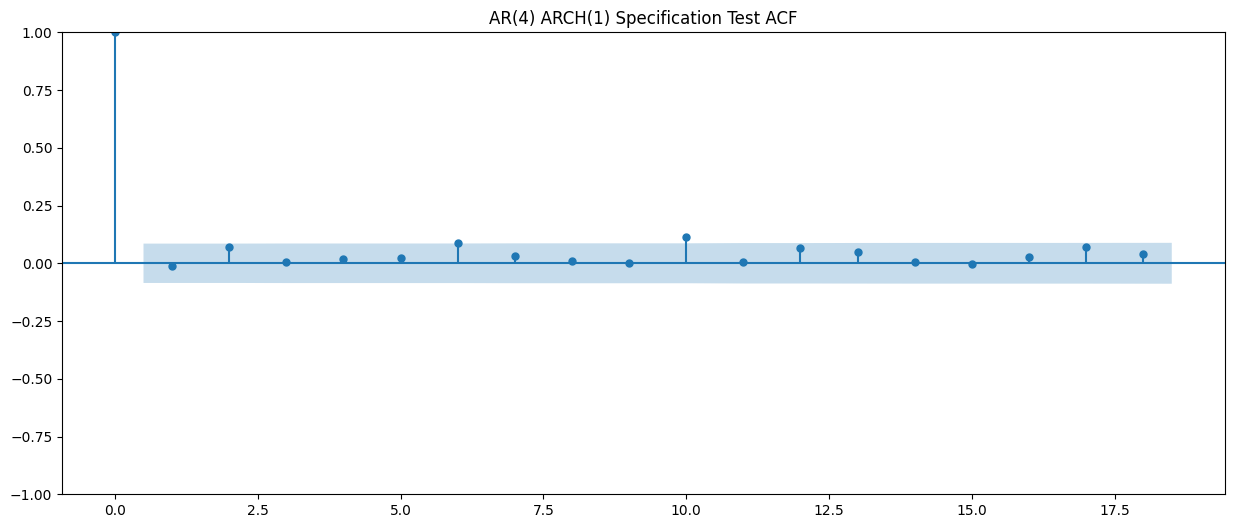

In [66]:
# Plot the acf of the specification test
sm.graphics.tsa.plot_acf(ar4arch1_spec_test, lags=18, title="AR(4) ARCH(1) Specification Test ACF");

In [67]:
ar4garch11_ljung_box = sm.stats.acorr_ljungbox(ar4garch11_spec_test, lags=18)
ar4garch11_ljung_box

,lb_stat,lb_pvalue
1,1.540613,0.214527
2,2.225624,0.328634
3,3.388078,0.335571
4,3.791518,0.434955
5,3.794509,0.579365
6,3.985054,0.678699
7,3.986422,0.781340
8,6.101311,0.635885
9,6.364119,0.702995
10,6.370918,0.783197


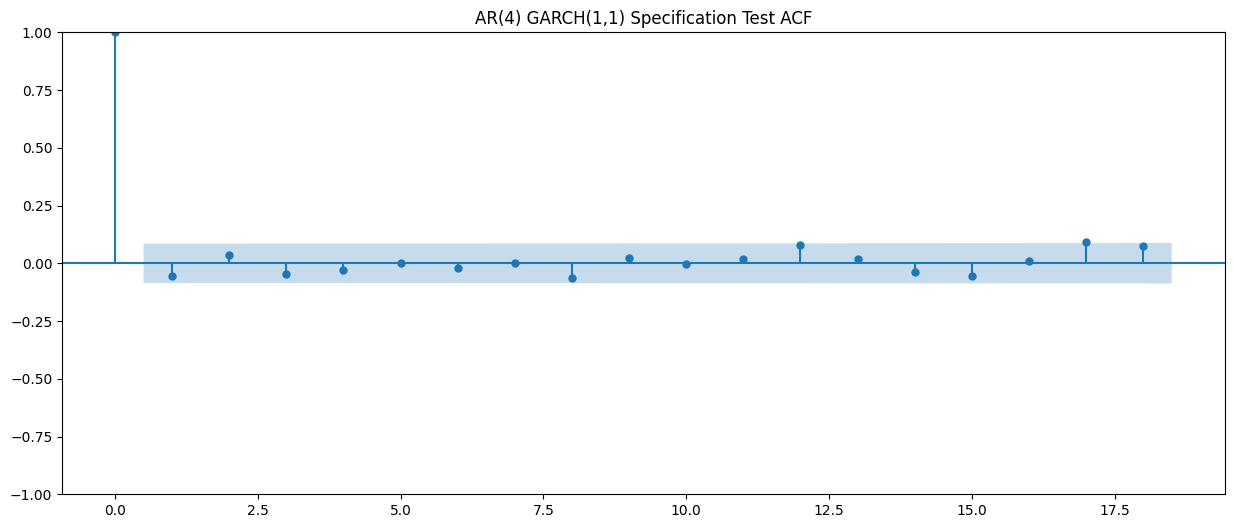

In [68]:
sm.graphics.tsa.plot_acf(ar4garch11_spec_test, lags=18, title="AR(4) GARCH(1,1) Specification Test ACF");

Interprétation à ajouter...

**4.e) Pour ces deux nouveaux modèles et les deux modèles étudiés dans la partie 3, tracez les fonctions de réponse impulsionnelle du second cas décrit dans la partie 3. Dans quelle mesure sont-elles différentes ?**

Reste à faire...

In [365]:
def compute_three_impulse_mixed(unit_impulse, sigma = 1):
    """Compute the impulse response for 3 periods

    Args:
        unit_impulse: A (1,n) array showing the impulse response on n periods
        sigma: The size of the input impulse

    Output:
        total_impulse: The Impulse on n periods given a choc in the first three periods
    """
    first_impulse = pd.Series(unit_impulse.transpose().reshape(-1)) * sigma
    second_impulse = first_impulse
    second_impulse = pd.concat([pd.Series([0]), second_impulse], ignore_index=True)
    second_impulse = second_impulse[0:-1]
    third_impulse = first_impulse
    third_impulse = pd.concat([pd.Series([0, 0]), third_impulse], ignore_index=True)
    third_impulse = third_impulse[0:-2]
    total_impulse = first_impulse + second_impulse + third_impulse
    return total_impulse

In [ ]:
eng = matlab.engine.start_matlab()

In [69]:
#Transform the variable into a suitable matlab object
mat_USDCAD = matlab.double(list(df_stoch["stoch_USDCAD"]))
vec_USDCAD = eng.transpose(mat_USDCAD)
vec_USDCAD

matlab.double([[-0.21968750164305106],[7.649618381968715],[0.16208478267438764],[2.181160097954926],[-0.08301105694634714],[0.7026523027680476],[0.2107611481827476],[0.43729386248436697],[-0.32711695256075757],[0.017571280483963392],[-0.0860393347156041],[-0.42865282536714844],[-0.8419534828152386],[-0.38736299279333863],[-0.5097106537374607],[-0.4141593878664196],[0.0608539809467068],[0.41614981448843125],[0.2033499644606529],[0.4680640113247314],[-0.13328039752567022],[0.36617929112230385],[-0.004757008634559412],[0.45312067990268545],[0.2923158917758073],[0.12344244836350882],[0.6425739926124052],[0.9618800099405966],[0.06047941494271569],[0.5074897474164786],[0.2420862362735754],[-0.34547434362819374],[-0.009836033179944081],[-0.7146707714397849],[-0.018402989515120538],[-0.6327341312451829],[-0.7219633003419546],[-0.6264359630871574],[-0.36371122048155513],[-0.39695264821348886],[-0.4922628780787086],[-0.21755534894909445],[0.5535817007825905],[-0.6553863759107159],[0.012997856195

In [359]:
#Estimate the models
ar4arch1_m = eng.arima('ARLags',matlab.double([1,4]),'Variance',eng.garch(0.0,1.0));
ar4arch1_matlab = eng.estimate(ar4arch1_m,vec_USDCAD)

ar4garch11_m = eng.arima('ARLags',matlab.double([1,4]),'Variance',eng.garch(1.0,1.0));
ar4garch11_matlab = eng.estimate(ar4garch11_m,vec_USDCAD)

In [360]:
#
steps = 20.0
impulse_ar4arch1_matlab = np.asarray(eng.impulse(ar4arch1_matlab, steps)).transpose()
impulse_ar4garch11_matlab = np.asarray(eng.impulse(ar4garch11_matlab, steps)).transpose()

In [366]:
impulse_res_ar4arch1 = compute_three_impulse_mixed(impulse_ar4arch1_matlab, sigma = -1.15)
impulse_res_ar4garch11 = compute_three_impulse_mixed(impulse_ar4garch11_matlab, sigma = -1.15)

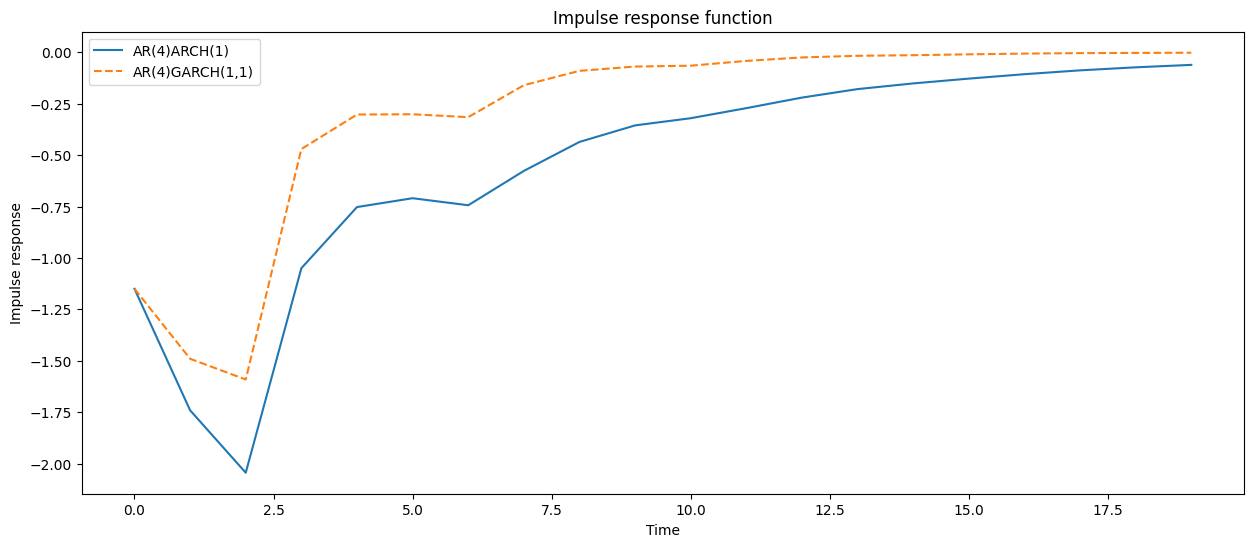

In [368]:
plt.plot(impulse_res_ar4arch1, label="AR(4)ARCH(1)")
plt.plot(impulse_res_ar4garch11, label="AR(4)GARCH(1,1)", linestyle="--")
plt.legend()
plt.title("Impulse response function")
plt.xlabel("Time")
plt.ylabel("Impulse response")
plt.show()

**4.f) Comme dans la partie 3, tracez les prévisions à un pas d'avance $\mathbb{E}_t(y_{t+1})$ pour la période couverte par l'échantillon de validation (holdout sample). Comparez-les avec celles obtenues dans la partie 3.**

In [190]:
# Get AR(4) GARCH(1,1) forecast
forecast_ar4 = ar4.forecast(steps=treshold).reset_index(drop=True)
forecast_garch11 = ar4garch11.forecast(horizon=treshold).mean['h.01'].iloc[-1]
forecast_ar4garch11 = forecast_ar4 + forecast_garch11

# Get ARMA(4,4) GARCH(1,1) forecast
forecast_arma_44 = arma44.forecast(steps=treshold).reset_index(drop=True)
forecast_garch11 = arma44garch11.forecast(horizon=treshold).mean['h.01'].iloc[-1]
forecast_arma44garch11 = forecast_arma_44 + forecast_garch11

# Change index to date for plotting
forecast_arma_44.index = df["date"].iloc[-treshold:]
forecast_ar4garch11.index = df["date"].iloc[-treshold:]
forecast_arma44garch11.index = df["date"].iloc[-treshold:]

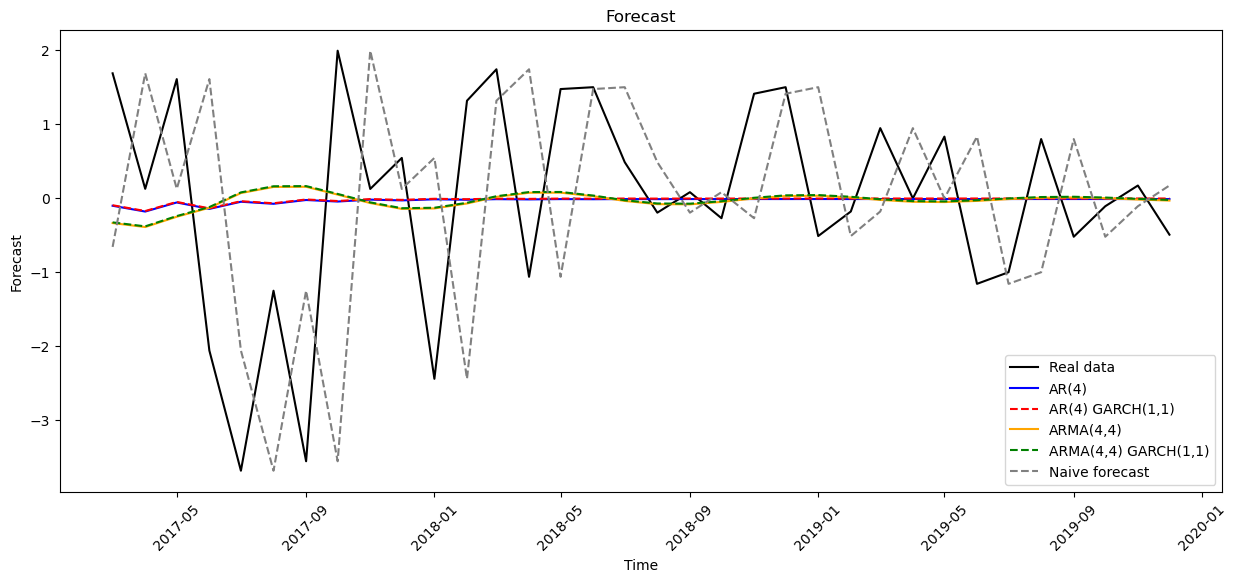

In [191]:
plt.plot(val_sample, label="Real data", color="black")
plt.plot(forecast_arma40, label="AR(4)", color="blue")
plt.plot(forecast_ar4garch11, label="AR(4) GARCH(1,1)", color="red", linestyle="--")
plt.plot(forecast_arma_44, label="ARMA(4,4)", color="orange")
plt.plot(forecast_arma44garch11, label="ARMA(4,4) GARCH(1,1)", color="green", linestyle="--")
plt.plot(forecast_naive, label="Naive forecast", color="grey", linestyle="--")
plt.legend()
plt.title("Forecast")
plt.xlabel("Time")
# rotate xticks by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Forecast")
plt.show()

**4.g) Comparez les erreurs quadratiques moyennes de la prévision à un pas (pour la série transformée !) pour les deux modèles sélectionnés dans la partie 3, les deux nouveaux modèles, la prévision naïve $\mathbb{E}_t(y_{t+1}) = y_t$
et la prévision paresseuse $\mathbb{E}_t(y_{t+1}) = 0$ pour tous les t. Cette dernière suppose que la série en
niveaux ne changera pas. Que pouvez-vous conclure ? La modélisation de la covariance conditionnelle était-elle utile ?**

In [192]:
mse_ar4garch11 = compute_mse(val_sample, forecast_ar4garch11)
mse_arma44garch11 = compute_mse(val_sample, forecast_arma44garch11)
mse_lazy = compute_mse(val_sample, [0]*34)

mse_df.insert(1, "AR(4) GARCH(1,1)", mse_ar4garch11, True)
mse_df.insert(3, "ARMA(4,4) GARCH(1,1)", mse_arma44garch11, True)
mse_df["Lazy forecast"] = mse_lazy
mse_df

,AR(4),"AR(4) GARCH(1,1)","ARMA(4,4)","ARMA(4,4) GARCH(1,1)",Naive forecast,Lazy forecast
MSE,1.986487,1.986162,2.090431,2.089893,3.832131,1.996051


Conclusion à ajouter...